DQN Agent Results:
Wins: 6 Losses: 29 Draws: 0
Final score = -23
Win percentage = 17.14%
% of times optimal action is chosen: 57.14

DDQN Agent Results:
Wins: 7 Losses: 27 Draws: 1
Final score = -20
Win percentage = 20.00%
% of times optimal action is chosen: 31.43

Optimal Agent Results:
Wins: 16 Losses: 16 Draws: 3
Final score = 0
Win percentage = 45.71%

Random Agent Results:
Wins: 12 Losses: 23 Draws: 0
Final score = -11
Win percentage = 34.29%
% of times optimal action is chosen: 42.86


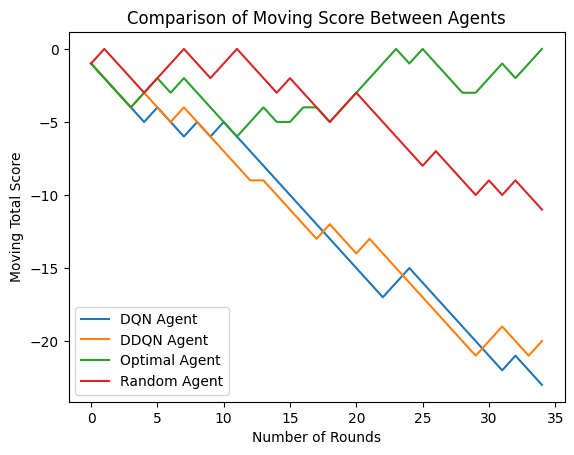

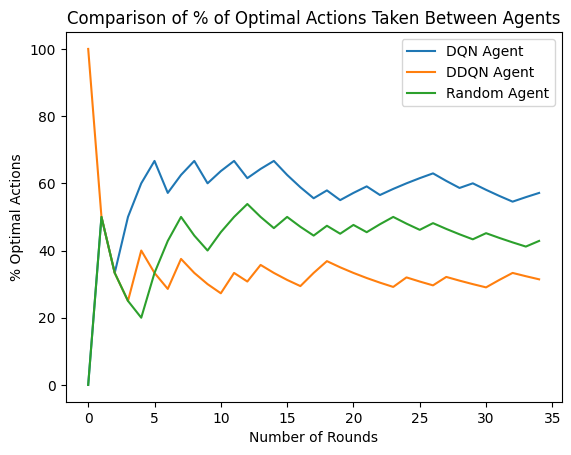

In [8]:
#PLEASE NOTE: The code below only runs on 'Google Collab', attempts to run on local IDE's is likely to import a different version of the Gym game environment 
# that doesnt accept "new_step_api=True" and also provides observations from the enivronment in a format that is incompatible with the structure of the provided code below.

# student ID Numbers

# Rhys Cooper: 201680340 
#Liam Francis: 201690632 
#Ryan Maxwell: 201328336 
#David Tate: 201688052 
#Thomas Williams: 201450922

import random
import torch
import numpy as np
import copy
from collections import deque
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

#Import Blackjack Environment from AiGym
env = gym.make('Blackjack-v1', new_step_api=True)

#Define Graph making function
def graph_maker(dictionary, title, y_axis_label):
            x = list(dictionary.keys())
            y = list(dictionary.values())
            
            plt.plot(x, y, '-')
            plt.xlabel('Number of Rounds')
            plt.ylabel(y_axis_label)
            plt.title(title)
            plt.show() 
#Initialise Deep Q Learning Neural Network  
class DQNN(torch.nn.Module):
    def __init__(self, n_of_states, hidden_L_size_one, hidden_L_size_two, hidden_L_size_three, n_of_actions, lr = 0.0001):
        #Inherit methods and attributes from Pytorch parent class
        super(DQNN, self).__init__()
        #Define fully connected layers
        self.FCL1 = torch.nn.Linear(n_of_states, hidden_L_size_one)
        self.FCL2 = torch.nn.Linear(hidden_L_size_one, hidden_L_size_two)
        self.FCL3 = torch.nn.Linear(hidden_L_size_two, hidden_L_size_three)
        self.FCL4 = torch.nn.Linear(hidden_L_size_three, n_of_actions)
        #Define activation function
        self.activation = torch.nn.ReLU()
        #Define optimiser
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = torch.nn.MSELoss()
    #Define forward pass and return Q value for SA     
    def forward(self, state):
       #Pass the vector through each layer and activate the output
        out = self.FCL1(state)
        out = self.activation(out)
        out = self.FCL2(out)
        out = self.activation(out)
        out = self.FCL3(out)
        out = self.activation(out)
        out = self.FCL4(out)
        #Return Q Values for each action in current state after passing through output layer
        Q_values = out
        return Q_values
#Define agent    
class Agent:
    def __init__(self, n_rounds, batch_size, epsilon, min_epsilon, eps_decay_rate, learning_rate=0.0001, gamma=0.99):
        self.n_of_states = 3 #Player's hand, dealer's hand, usable ace
        self.n_of_actions = 2 #Hit or Stick
        self.memory = deque(maxlen=20000)
        #Set training sample batch size
        self.batch_size = batch_size
        #Initialse DQNN for calculating Q value
        self.DQNN_policy = DQNN(self.n_of_states, 128, 64, 32, self.n_of_actions, learning_rate)
        #Set exploration epsilon
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        #Set rate of epsilon decay
        self.gamma = gamma
        self.eps_decay_rate = eps_decay_rate
        self.basic_strategy_accuracy_counter = 0 
        self.n_rounds = n_rounds
    #Here we describe the function used to store each observation pass to memory    
    def add_to_memory(self, mem_clip):

        state = mem_clip[0]
        action= mem_clip[1]
        # print(mem_clip)
        next_state = mem_clip[2][0]
        reward= mem_clip[2][1]
        # done_next = mem_clip[2][2]
        done = mem_clip[2][2]
        
        self.memory.append((state, action, reward, next_state, done))

    #Here we create the function to format the observations that will be later used to train the DQNN    
    def observation_formater(self, full_obv):
        full_obv_list = list(full_obv)    

        if len(full_obv_list) == 3:
          state = full_obv_list
          if state[2] == False:
            state[2] = 0.0
          if state[2] == True:
            state[2] = 1.0
          return state

        if len(full_obv) == 5:
          state = list(full_obv_list[0])
          if state[2] == False:
            state[2] = 0.0
          if state[2] == True:
            state[2] = 1.0

          obsv_list = []     
          obsv_list.append(state)
          reward = full_obv_list[1]
          obsv_list.append(reward)
          ended_round = full_obv_list[2]
          obsv_list.append(ended_round)

          return obsv_list
    #Here we decide the action to be taken by the agent.
    def get_action(self, state):
    #If the randomly generated number is less than the epsilon value, select random action.
    #The higher the epsilon value, the more exploration will take place
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_of_actions)
        else:
            #We turn the current state into a tensor
            state = torch.tensor(state)
            #Make a prediction of the Q Values for the current state
            Q_value_actions = self.DQNN_policy(state)
            #Here we return the action with the highest peredicted Q value
            max_Q_value_action = torch.argmax(Q_value_actions).item()
        return max_Q_value_action
    #Here we hard-code the optimal strategy to compare against our DQNN
    def optimal_strategy(self, state, action):
        player_total = state[0]
        dealer_card = state[1]
        useable_ace = state[2]
        
        # If the player has a soft 17 or lower, hit
        if player_total <= 17 and (useable_ace or player_total < 17):
            best_action = 1.0
        
        # If the player has a hard 12-16 and the dealer's card is 7 or higher, hit
        if 12 <= player_total <= 16 and dealer_card >= 7:
            best_action = 1.0
        
        # If the player has a hard 12-16 and the dealer's card is 6 or lower, stand
        if 12 <= player_total <= 16 and dealer_card <= 6:
            best_action = 0.0
        
        # If the player has a hard 17-21, stand
        if 17 <= player_total <= 21:
            best_action = 0.0
            
        if action == best_action:
            self.basic_strategy_accuracy_counter += 1
    #Define the function to calculate the accuracy        
    def get_accuracy(self, rounds):
        accuracy = self.basic_strategy_accuracy_counter / rounds  * 100
        return accuracy           
    
    #Here is the training loop for the DQNN
    def train(self): 
        self.DQNN_policy.train()

         #Create batch of training samples from memory
        mini_batch = random.sample(self.memory, self.batch_size)

        #Extract states,actions,rewards,next_states and dones from batch
        states = list(sample[0] for sample in mini_batch)
        states = torch.tensor(states)
        
        actions = list(sample[1]for sample in mini_batch)
        actions = torch.tensor(actions)

        rewards = list(sample[2]for sample in mini_batch)
        rewards = torch.tensor(rewards)
        
        next_states = list(sample[3] for sample in mini_batch)
        next_states = torch.tensor(next_states)
        
        dones = list(sample[4] for sample in mini_batch)
        dones = torch.tensor(dones)
        
        #Calculate predicted Q value from states according to current DQNN
        states_Q = self.DQNN_policy(states)
        
         #Calculate Q values of next states from current
        next_states_Q = self.DQNN_policy(next_states)

        target_qs = []
  
        with torch.no_grad():
          #Iterate through states
          for j in range(self.batch_size):
              if dones[j]:
                  #If state is terminal, return reward
                  q = rewards[j]
              else:
                #Else, calculate Q value of current state using Bellman Equation
                  max_future_q = torch.max(next_states_Q[j])
                  q = rewards[j] + (self.gamma * max_future_q)   
                  
              current_state_qs = states_Q[j].clone()
              action_chosen = actions[j].item()
              #Naturally this means only the action taken gets updated.
              current_state_qs[action_chosen] = q
              target_qs.append(current_state_qs)
          #Convert target Qs to stack of tensors to perform batch update  
          target_qs = torch.stack(target_qs)
         
        #Calculate Loss across training batch    
        loss = self.DQNN_policy.loss(target_qs, states_Q)
        loss_for_graph = loss
        #Zero the gradients ahead of next training loop
        self.DQNN_policy.optimizer.zero_grad()
        #Perform Back-prop to calculate gradient update
        loss.backward()
        #Update gradients according to selected optimiser
        self.DQNN_policy.optimizer.step()
        #Set model to evaluate
        self.DQNN_policy.eval()

        return loss_for_graph
    
    def play_rounds(self, graph_bool):
        #Initialise variables for tracking 
        win_count = 0
        loss_count = 0
        draw_count = 0
        moving_total = 0
        moving_total_dict = {}
        loss_dict = {}
        accuracy_dict = {}
        #Iterate through loop for predetermined number of rounds
        for round in range(self.n_rounds):
            #Calculate epsilon value for exploration, with regard to the decay rate
            self.epsilon *= 1 / (1 + self.eps_decay_rate * round)
            #Reset the environment for new trial
            state = env.reset()
            #Retrieve next state
            next_state = self.observation_formater(state)
            ended_round = False
#While the game isn't in a terminal state
            while not ended_round:
                #Transition to next state
                state = next_state
                #Get action, either randomly (with probability epsilon), or computed by our DQNN  
                action = self.get_action(state)
                #Take action and observe new state
                next_observation = (env.step(action))
                #Format observation
                next_observation = self.observation_formater(next_observation)
                #Store observation in memory
                mem_clip = [state, action, next_observation]
                self.add_to_memory(mem_clip)
                #Observe next state (as given bhy environment)
                next_state = next_observation[0]
                #Observe reward from next state and if the next state is terminal
                reward = next_observation[1]
                ended_round = next_observation[2]

                #When the observations in memory reach the desired batch size, train the model and record the loss  
                if len(self.memory)  > self.batch_size:
                    loss = self.train().item()
                    loss_dict[round] = loss

            #increase accuracy for this round if we were playing by the optimal strategy        
            self.optimal_strategy(state, action) 
            accuracy_dict[round] = self.get_accuracy(round+1)        

             #Log the reward from the environments
            if reward == 1.0:
                win_count += 1
                moving_total += 1
                moving_total_dict[round] = moving_total 
            if reward == 0.0:
                draw_count += 1  
                moving_total += 0
                moving_total_dict[round] = moving_total  
            if reward == -1.0:
                loss_count += 1 
                moving_total += -1
                moving_total_dict[round] = moving_total    
                   
        total = win_count + loss_count + draw_count
        print("Wins:", win_count, "Losses:", loss_count, "Draws:", draw_count)
        print(f"Final score = {win_count - loss_count}")
        print(f"Win percentage = {100* win_count/(win_count+loss_count+draw_count):.2f}%")
        print(f"% of times optimal action is chosen: {self.get_accuracy(self.n_rounds):.2f}")
        
        if graph_bool == True:
          graph_maker(moving_total_dict, f"Cumulative Reward Across {self.n_rounds} Rounds", "Cumulative Reward")
        if graph_bool == True:
          graph_maker(accuracy_dict, f"Percentage of optimal actions Across {self.n_rounds} Rounds", "% Optimal Actions")  

        return moving_total_dict, accuracy_dict     

class Double_Deep_Q_Agent(Agent):
  def __init__(self, n_rounds, batch_size, epsilon, min_epsilon, eps_decay_rate, learning_rate=0.0001, gamma=0.99, update_freq=10):
      super().__init__(n_rounds, batch_size, epsilon, min_epsilon, eps_decay_rate, learning_rate, gamma)
      self.DQNN_target = copy.deepcopy(self.DQNN_policy)
      self.update_freq = update_freq

  def train_policy_network(self): 
      self.DQNN_policy.train()
      mini_batch = random.sample(self.memory, self.batch_size)
      
      states = list(sample[0] for sample in mini_batch)
      states = torch.tensor(states)
      
      actions = list(sample[1]for sample in mini_batch)
      actions = torch.tensor(actions)

      rewards = list(sample[2]for sample in mini_batch)
      rewards = torch.tensor(rewards)
      
      next_states = list(sample[3] for sample in mini_batch)
      next_states = torch.tensor(next_states)
      
      dones = list(sample[4] for sample in mini_batch)
      dones = torch.tensor(dones)
      
      states_Q = self.DQNN_policy(states)
      
      next_states_Q = self.DQNN_target(next_states)

      target_qs = []

      with torch.no_grad():
        for j in range(self.batch_size):
            if dones[j]:
                q = rewards[j]
            else:
                max_future_q = torch.max(next_states_Q[j])
                q = rewards[j] + (self.gamma * max_future_q)   
                
            current_state_qs = states_Q[j].clone()
            action_chosen = actions[j].item()
            #Naturally this means only the action taken gets updated.
            current_state_qs[action_chosen] = q
            target_qs.append(current_state_qs)
          
        target_qs = torch.stack(target_qs)
          
      loss = self.DQNN_policy.loss(target_qs, states_Q)
      loss_for_graph = loss
      
      self.DQNN_policy.optimizer.zero_grad()
      loss.backward()
      self.DQNN_policy.optimizer.step()
      self.DQNN_policy.eval()

      return loss_for_graph

  def play_rounds(self, graph_bool=False):
      win_count = 0
      loss_count = 0
      draw_count = 0
      moving_total = 0
      moving_total_dict = {}
      loss_dict = {}
      accuracy_dict = {}

      for round in range(self.n_rounds):

          self.epsilon *= 1 / (1 + self.eps_decay_rate * round)
          state = env.reset()
          next_state = self.observation_formater(state)
          ended_round = False

          while not ended_round:
              state = next_state  
              action = self.get_action(state)
              next_observation = (env.step(action))
              next_observation = self.observation_formater(next_observation)
              mem_clip = [state, action, next_observation]
              self.add_to_memory(mem_clip)
              next_state = next_observation[0]
              reward = next_observation[1]
              ended_round = next_observation[2]

              if len(self.memory) > self.batch_size:
                  loss = self.train_policy_network().item()
                  loss_dict[round] = loss
              
              if round % self.update_freq == 0:
                  DQNN_policy_state_dict = self.DQNN_policy.state_dict()
                  self.DQNN_target.load_state_dict(DQNN_policy_state_dict)

          self.optimal_strategy(state, action) 
          accuracy_dict[round] = self.get_accuracy(round+1)        

          if reward == 1.0:
              win_count += 1
              moving_total += 1
              moving_total_dict[round] = moving_total 
          if reward == 0.0:
              draw_count += 1  
              moving_total += 0
              moving_total_dict[round] = moving_total  
          if reward == -1.0:
              loss_count += 1 
              moving_total += -1
              moving_total_dict[round] = moving_total    
      
      total = win_count + loss_count + draw_count
      print("Wins:", win_count, "Losses:", loss_count, "Draws:", draw_count)
      print(f"Final score = {win_count - loss_count}")
      print(f"Win percentage = {100* win_count/(win_count+loss_count+draw_count):.2f}%")
      print(f"% of times optimal action is chosen: {self.get_accuracy(self.n_rounds):.2f}")
      
      if graph_bool == True:
        graph_maker(moving_total_dict, f"Cumulative Reward Across {self.n_rounds} Rounds", "Cumulative Reward")
      if graph_bool == True:
        graph_maker(accuracy_dict, f"Percentage of optimal actions Across {self.n_rounds} Rounds", "% Optimal Actions")  

      return moving_total_dict, accuracy_dict 

class Optimal_Agent(Agent):
    def __init__(self, n_rounds, batch_size, epsilon, min_epsilon, eps_decay_rate, learning_rate=0.0001, gamma=0.99):
      super().__init__(n_rounds, batch_size, epsilon, min_epsilon, eps_decay_rate, learning_rate, gamma)
      self.name = "Optimal Agent"

    def get_action(self, state):
        player_total = state[0]
        dealer_card = state[1]
        useable_ace = state[2]
        
        # If the player has a soft 17 or lower, hit
        if player_total <= 17 and (useable_ace or player_total < 17):
            action = 1
        
        # If the player has a hard 12-16 and the dealer's card is 7 or higher, hit
        if 12 <= player_total <= 16 and dealer_card >= 7:
            action = 1

        # If the player has a hard 12-16 and the dealer's card is 6 or lower, stand
        if 12 <= player_total <= 16 and dealer_card <= 6:
            action = 0
        
        # If the player has a hard 17-21, stand
        if 17 <= player_total <= 21:
            action = 0
            
        return action

    def play_rounds(self, graph_bool=False):
        win_count = 0
        loss_count = 0
        draw_count = 0
        moving_total = 0
        moving_total_dict = {}
        loss_dict = {}
        
        for round in range(self.n_rounds):
            state = env.reset()
            next_state = self.observation_formater(state)
            ended_round = False
            while not ended_round:
                state = next_state  
                action = self.get_action(state)
                next_observation = (env.step(action))
                next_observation = self.observation_formater(next_observation)
                next_state = next_observation[0]
                reward = next_observation[1]
                ended_round = next_observation[2]      

            if reward == 1.0:
                win_count += 1
                moving_total += 1
                moving_total_dict[round] = moving_total 
            if reward == 0.0:
                draw_count += 1  
                moving_total += 0
                moving_total_dict[round] = moving_total  
            if reward == -1.0:
                loss_count += 1 
                moving_total += -1
                moving_total_dict[round] = moving_total    
    
        total = win_count + loss_count + draw_count
        print("Wins:", win_count, "Losses:", loss_count, "Draws:", draw_count)
        print(f"Final score = {win_count - loss_count}")
        print(f"Win percentage = {100* win_count/(win_count+loss_count+draw_count):.2f}%")
        
        if graph_bool == True:
            graph_maker(moving_total_dict, f"Cumulative Reward Across {self.n_rounds} Rounds", "Cumulative Reward")

        return moving_total_dict

class Random_Agent(Agent):
  def __init__(self, n_rounds, batch_size, epsilon, min_epsilon, eps_decay_rate, learning_rate, gamma):
        super().__init__(n_rounds, batch_size, epsilon, min_epsilon, eps_decay_rate, learning_rate, gamma)

  def get_action(self, state):
        return np.random.randint(0, self.n_of_actions)

  def play_rounds(self, graph_bool=False):
        win_count = 0
        loss_count = 0
        draw_count = 0
        moving_total = 0
        moving_total_dict = {}
        loss_dict = {}
        accuracy_dict = {}

        for round in range(self.n_rounds):
            state = env.reset()
            next_state = self.observation_formater(state)
            ended_round = False

            while not ended_round:
                state = next_state  
                action = self.get_action(state)
                next_observation = (env.step(action))
                next_observation = self.observation_formater(next_observation)
                next_state = next_observation[0]
                reward = next_observation[1]
                ended_round = next_observation[2]
                    
            self.optimal_strategy(state, action) 
            accuracy_dict[round] = self.get_accuracy(round+1)        

            if reward == 1.0:
                win_count += 1
                moving_total += 1
                moving_total_dict[round] = moving_total 
            if reward == 0.0:
                draw_count += 1  
                moving_total += 0
                moving_total_dict[round] = moving_total  
            if reward == -1.0:
                loss_count += 1 
                moving_total += -1
                moving_total_dict[round] = moving_total    
                
        total = win_count + loss_count + draw_count
        print("Wins:", win_count, "Losses:", loss_count, "Draws:", draw_count)
        print(f"Final score = {win_count - loss_count}")
        print(f"Win percentage = {100* win_count/(win_count+loss_count+draw_count):.2f}%")
        print(f"% of times optimal action is chosen: {self.get_accuracy(self.n_rounds):.2f}")
        
        if graph_bool == True:
          graph_maker(moving_total_dict, f"Cumulative Reward Across {self.n_rounds} Rounds", "Cumulative Reward")
        if graph_bool == True:
          graph_maker(accuracy_dict, f"Percentage of optimal actions Across {self.n_rounds} Rounds", "% Optimal Actions")  

        return moving_total_dict, accuracy_dict


def DQN_agent_vs_DDQN(n_rounds):
  agentDQN = Agent(n_rounds, batch_size = 125, epsilon = 1, min_epsilon=0.0125, eps_decay_rate = 0.01, learning_rate=0.0001, gamma=0.99)

  agentDDQN = Double_Deep_Q_Agent(n_rounds, batch_size = 125, epsilon = 1, min_epsilon=0.0125, eps_decay_rate = 0.01, learning_rate=0.0001, gamma=0.99, update_freq=15)
  
  print("DQN Agent Results:")
  DQN_cum_score, DQN_optimal_actions = agentDQN.play_rounds(graph_bool=False)
  
  print("\nDDQN Agent Results:")
  DDQN_cum_score, DDQN_optimal_actions = agentDDQN.play_rounds(graph_bool=False)

  #Make cumulative score graph 
  plt.figure()
  x1 = list(DQN_cum_score.keys())
  y1 = list(DQN_cum_score.values())
  
  x2 = list(DDQN_cum_score.keys())
  y2 = list(DDQN_cum_score.values())

  plt.plot(x1, y1, label='DQN Agent')
  plt.plot(x2, y2, label='DDQN Agent')
  plt.xlabel('Number of Rounds')
  plt.ylabel('Moving Total Score')
  plt.title('Comparison of Moving Score Between DQN Agent and Double DQN Agent')
  plt.legend()
  plt.show

  #Make % optimal actions graph 
  plt.figure()
  x1 = list(DQN_optimal_actions.keys())
  y1 = list(DQN_optimal_actions.values())
  
  x2 = list(DDQN_optimal_actions.keys())
  y2 = list(DDQN_optimal_actions.values())

  plt.plot(x1, y1, label='DQN Agent')
  plt.plot(x2, y2, label='DDQN Agent')
  plt.xlabel('Number of Rounds')
  plt.ylabel('% Optimal Actions')
  plt.title('Comparison of % of Optimal Actions Taken Between DQN Agent and Double DQN Agent')
  plt.legend()
  plt.show


def Agent_vs_optimal(n_rounds):
  '''
  Returns a plot showing the cumulative returns between optimal strategy and the DQN agent
  '''
  opt_agent = Optimal_Agent(n_rounds, batch_size = 125, epsilon = 1, min_epsilon=0.0125, eps_decay_rate = 0.01, learning_rate=0.0001, gamma=0.99)
  opt_agent_results = opt_agent.play_rounds(graph_bool=False)

  agentDQN = Agent(n_rounds, batch_size = 125, epsilon = 1, min_epsilon=0.0125, eps_decay_rate = 0.01, learning_rate=0.0001, gamma=0.99)
  agentDQN.DQNN_model
  agentDQN_results = agentDQN.play_rounds(graph_bool=False)[0]

  #Make the graph 
  x1 = list(opt_agent_results.keys())
  y1 = list(opt_agent_results.values())
  
  x2 = list(agentDQN_results.keys())
  y2 = list(agentDQN_results.values())

  plt.plot(x1, y1, label='DQN Agent')
  plt.plot(x2, y2, label='Optimal Agent')
  plt.xlabel('Number of Rounds')
  plt.ylabel('Moving Total Score')
  plt.title('Comparison of Moving Score Between DQN Agent and Optimal Agent')
  plt.legend()


def DQN_agent_learning_optimal_strategy(n_rounds):  
  '''
  Returns the plot showing the DQN agent learning the optimal stratergy
  '''
  agentDQN = Agent(n_rounds, batch_size = 125, epsilon = 1, min_epsilon=0.0125, eps_decay_rate = 0.01, learning_rate=0.0001, gamma=0.99)
  agentDQNresults = agentDQN.play_rounds(graph_bool=True) 


def Agent_vs_random(n_rounds):
  '''
  Returns a combined plot of the agents cumulative reward compared to random agent
  '''
  agent1 = Agent(n_rounds, batch_size = 125, epsilon = 1, eps_decay_rate = 0.01, eps_decay= True)
  agent1results = agent1.play_rounds(graph_bool=False)
  agent_1_moving_total = agent1results[0]

  agent_random = Agent(n_rounds, batch_size = 125, epsilon = 1, eps_decay_rate = 0.01, eps_decay= False)
  agent_random.DQNN_model
  agent_random_results = agent_random.play_rounds(graph_bool=False)
  agent_random_moving_total = agent_random_results[0]

  #Make the graph 
  x1 = list(agent_1_moving_total.keys())
  y1 = list(agent_1_moving_total.values())
  
  x2 = list(agent_random_moving_total.keys())
  y2 = list(agent_random_moving_total.values())

  plt.plot(x1, y1, label='DQN Agent')
  plt.plot(x2, y2, label='Random Agent')
  plt.xlabel('Number of Rounds')
  plt.ylabel('Moving Total Score')
  plt.title('Comparison of Moving Score Between DQN Agent and Random Agent')
  plt.legend()


def hyperparameter_exploration_plotter(n_rounds, batch_size, eps1, eps2, eps3, eps_decay_rate1, eps_decay_rate2, eps_decay_rate3, eps_decay):
  '''
  Creates 3 agents with different combinations of hyperparameter values and plots the cumulative reward 
  for each one on the same plot for comparison
  '''
  agent_ep_1 = Agent(n_rounds= n_rounds, Random_bool= False, batch_size = batch_size, epsilon = eps1, eps_decay_rate1 = eps_decay_rate1, eps_decay= eps_decay)
  agent_ep_1.DQNN_model
  agent_ep_1_results = agent_ep_1.play_rounds(graph_bool=False)
  agent_ep_1_moving_total = agent_ep_1_results[0]

  agent_ep_2 = Agent(n_rounds= n_rounds, Random_bool= False, batch_size = batch_size, epsilon = eps2, eps_decay_rate2 = eps_decay_rate2, eps_decay= eps_decay)
  agent_ep_2.DQNN_model
  agent_ep_2_results = agent_ep_2.play_rounds(graph_bool=False)
  agent_ep_2_moving_total = agent_ep_2_results[0]

  agent_ep_3 = Agent(n_rounds= n_rounds, Random_bool= False, batch_size = batch_size, epsilon = eps3, eps_decay_rate3 = eps_decay_rate3, eps_decay= eps_decay)
  agent_ep_3.DQNN_model
  agent_ep_3_results = agent_ep_3.play_rounds(graph_bool=False)
  agent_ep_3_moving_total = agent_ep_3_results[0]


  #Make the graph 
  x1 = list(agent_ep_1_moving_total.keys())
  y1 = list(agent_ep_1_moving_total.values())
  
  x2 = list(agent_ep_2_moving_total.keys())
  y2 = list(agent_ep_2_moving_total.values())

  x3 = list(agent_ep_3_moving_total.keys())
  y3 = list(agent_ep_3_moving_total.values())


  plt.plot(x1, y1, label=f'Batch size={batch_size}, epsilon={eps1}, epsilon_decay_rate={eps_decay_rate1}')
  plt.plot(x2, y2, label=f'Batch size={batch_size}, epsilon={eps2}, epsilon_decay_rate={eps_decay_rate2}')
  plt.plot(x3, y3, label=f'Batch size={batch_size}, epsilon={eps3}, epsilon_decay_rate={eps_decay_rate3}')

  plt.xlabel('Number of Rounds')
  plt.ylabel('Moving Total Score')
  plt.title(f'Comparison of Moving Score Between Different Hyperparameter Combinations, with epsilon_decay={eps_decay}')
  plt.legend()


def compare_all_agents(n_rounds):
  '''
  Creates 4 agents with different policies. plots the cumulative reward, also known as total moving score for each one on the same plot for comparison. Also plots 
  the percentage optimal actions chosen relative to blackjack 'basic stratergy'.
  '''

  DQN_agent = Agent(n_rounds, batch_size=125, epsilon=1, min_epsilon=0.001, eps_decay_rate=0.0005, learning_rate=0.01, gamma=0.5)
  print("DQN Agent Results:")
  DQN_cum_score, DQN_optimal_actions = DQN_agent.play_rounds(graph_bool=False)

  DDQN_agent = Double_Deep_Q_Agent(n_rounds, batch_size=125, epsilon=1, min_epsilon=0.001, eps_decay_rate=0.0005, learning_rate=0.01, gamma=0.5, update_freq=12)
  print("\nDDQN Agent Results:")
  DDQN_cum_score, DDQN_optimal_actions = DDQN_agent.play_rounds(graph_bool=False)

  Optimal_agent = Optimal_Agent(n_rounds, batch_size=125, epsilon=1, min_epsilon=0.001, eps_decay_rate=0.0005, learning_rate=0.01, gamma=0.5)
  print("\nOptimal Agent Results:")
  Optimal_cum_score = Optimal_agent.play_rounds(graph_bool=False)

  Random_agent = Random_Agent(n_rounds, batch_size=125, epsilon=1, min_epsilon=0.001, eps_decay_rate=0.0005, learning_rate=0.01, gamma=0.5)
  print("\nRandom Agent Results:")
  Random_cum_score, Random_optimal_actions = Random_agent.play_rounds(graph_bool=False)

  #Make cumulative score graph 
  plt.figure()
  x1 = list(DQN_cum_score.keys())
  y1 = list(DQN_cum_score.values())
  
  x2 = list(DDQN_cum_score.keys())
  y2 = list(DDQN_cum_score.values())

  x3 = list(Optimal_cum_score.keys())
  y3 = list(Optimal_cum_score.values())

  x4 = list(Random_cum_score.keys())
  y4 = list(Random_cum_score.values())

  plt.plot(x1, y1, label='DQN Agent')
  plt.plot(x2, y2, label='DDQN Agent')
  plt.plot(x3, y3, label='Optimal Agent')
  plt.plot(x4, y4, label='Random Agent')
  plt.xlabel('Number of Rounds')
  plt.ylabel('Moving Total Score')
  plt.title('Comparison of Moving Score Between Agents')
  plt.legend()
  plt.show

  #Make % optimal actions graph 
  plt.figure()
  x1 = list(DQN_optimal_actions.keys())
  y1 = list(DQN_optimal_actions.values())
  
  x2 = list(DDQN_optimal_actions.keys())
  y2 = list(DDQN_optimal_actions.values())
  
  x3 = list(Random_optimal_actions.keys())
  y3 = list(Random_optimal_actions.values())

  plt.plot(x1, y1, label='DQN Agent')
  plt.plot(x2, y2, label='DDQN Agent')
  plt.plot(x3, y3, label='Random Agent')
  plt.xlabel('Number of Rounds')
  plt.ylabel('% Optimal Actions')
  plt.title('Comparison of % of Optimal Actions Taken Between Agents')
  plt.legend()
  plt.show


# runs the "compare all agents" function for 35000 rounds of blackjack. returns the two graphs and the metrics used in the results section of the report: a graph of 
# moving total score and a graph of percentage optimal actions. Expected run time is 7.5 minutes. 

compare_all_agents(35000)
